In [21]:
import pandas as pd
import re
import spacy
from es_lemmatizer import lemmatize
import spacy
from nltk.corpus import stopwords
from time import time

In [3]:
nlp = spacy.load("es")
nlp.add_pipe(lemmatize, after="tagger")


def lemmatize(text):
    return [x.lemma_ for x in nlp(text)]

stop_words = list(set([lemmatize(sw)[0] for sw in stopwords.words('spanish')]))

def remove_stopwords(tokens):
    return [w for w in tokens if w not in stop_words+[';',',','.','!','?']]

In [4]:
nlp('as asdfasdf asdfasdf')

as asdfasdf asdfasdf

In [5]:
data = pd.read_json("tweets_cmi/cmilanoticia_2014_2019.json")

In [6]:
data.head()

fullname                  id  likes  replies         reply_to_id  \
0       Jorge Galeano  640675275454476288      0        0  640670865735200768   
1       Gloria Moreno  640674744451395584      0        0  640672524888576000   
2       NOTICIERO CM&  640672524888576000      4        1  640672524888576000   
3  JUAN G CARDONA IZA  640672472543678464      0        0  640567139632549888   
4      EFREY MARTINEZ  640672288396976128      0        0  640670865735200768   

   retweets                                               text  \
0         0  @claudiapcnn @WRadioColombia @CMILANOTICIA. Se...   
1         0                      @CMILANOTICIA celebralo yamit   
2         2      Gol de Santa Fe en clásico contra Millonarios   
3         0              @CMILANOTICIA Y donde está Farcmanuel   
4         0  @claudiapcnn @WRadioColombia @CMILANOTICIA.  A...   

            timestamp                                         url  \
0 2015-09-06 23:57:43    /JorgeGaleano3/status/640675275454476288   
1 2015-09-06 23:55:36  /gloriamoreno248/status/640674744451395585   
2 2015-09-06 23:46:47     /CMILANOTICIA/status/640672524888576000   
3 2015-09-06 23:46:35  /JUANGCARDONAIZA/status/640672472543678464   
4 2015-09-06 23:45:51   /EDITORCONTADOR/status/640672288396976128   

              user  
0    JorgeGaleano3  
1  gloriamoreno248  
2     CMILANOTICIA  
3  JUANGCARDONAIZA  
4   EDITORCONTADOR

In [7]:
def cleanTweet(tweet):
    term = 'CMILANOTICIA'
    regex= r'(\w*@\w*\.*\w*|http\S*|RT\w*|<.*>|{}|pictwittercom/.*)'.format('|'.join(term.lower().split()))
    cleaned = re.sub(regex,'',tweet, flags = re.IGNORECASE)
    cleaned = ' '.join(cleaned.split())
    cleaned = re.sub('[¡!@#$:).;,¿?&]', '', cleaned.lower())
    return cleaned

In [8]:
def lemma(tweet):
    clean = cleanTweet(tweet)
    doc = nlp(clean)
    lista = []
    for token in doc:
        lista.append(token.lemma_)
    return ' '.join(remove_stopwords(lista))

In [9]:
tweets = data[data['user']=='CMILANOTICIA'].iloc[:2000]['text'].apply(lemma)

In [10]:
textos = tweets.apply(lambda x: x.split()).values

In [11]:
from gensim.corpora.dictionary import Dictionary
# Create a corpus from a list of texts
common_dictionary = Dictionary(textos)
common_corpus = [common_dictionary.doc2bow(text) for text in textos]

In [12]:
from gensim.models.ldamodel import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=10)

In [15]:
other_texts = ['esta es una noticia terrible y violenta'.split()]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]
unseen_doc = other_corpus[0]
vector = lda[unseen_doc]

### tarea

Para cada texto en textos sacar el vector lda. Sacar el índice con mayor probabilidad de  este vector. Hacer un pandas dataframe que tenga una columna igual al texto, y otra columna igual al índice o etiqueta del cluster.

In [18]:
import fastText

In [22]:
print("Fitting FastText model...")
t0 = time()
with open("textos.txt", "w") as f:
    for texto in textos:
        f.write(' '.join(texto))
        f.write('\n')
    
model = fastText.train_unsupervised(input='textos.txt', epoch=30, minCount=20, wordNgrams=2, dim=10)
model.save_model("model.bin")

print("done in %0.1fm." % ((time() - t0)/60))

Fitting FastText model...
done in 0.0m.


In [23]:
import umap

In [24]:
vectores = [model.get_sentence_vector(x) for x in tweets.values]

In [25]:
print("Embedding vectors in 2D...")
t0 = time()
embed = umap.UMAP(n_neighbors=5, min_dist=0.8)
embed.fit(vectores)
print("done in %0.1fm." % ((time() - t0)/60))

Embedding vectors in 2D...
done in 0.1m.


In [26]:
import matplotlib.pyplot as plt

In [27]:
transformed = embed.transform(vectores)

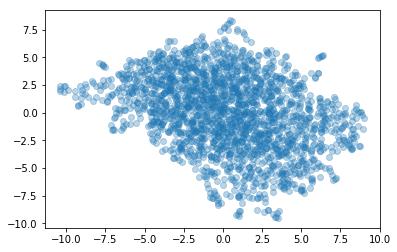

In [29]:
plt.scatter(*transformed.T, alpha=0.3)
plt.show()